# Final Presentation

Modify this notebook as the presentation notebook of your final presentation.

In [ ]:
print("Hello world!")

In [ ]:
%matplotlib inline
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation, rc
from functools import partial

#%pip install power_grid_model

from power_grid_model.utils import json_deserialize, json_serialize

import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms

MovieWriter Pillow unavailable; using Pillow instead.


KeyError: 'MPEG'

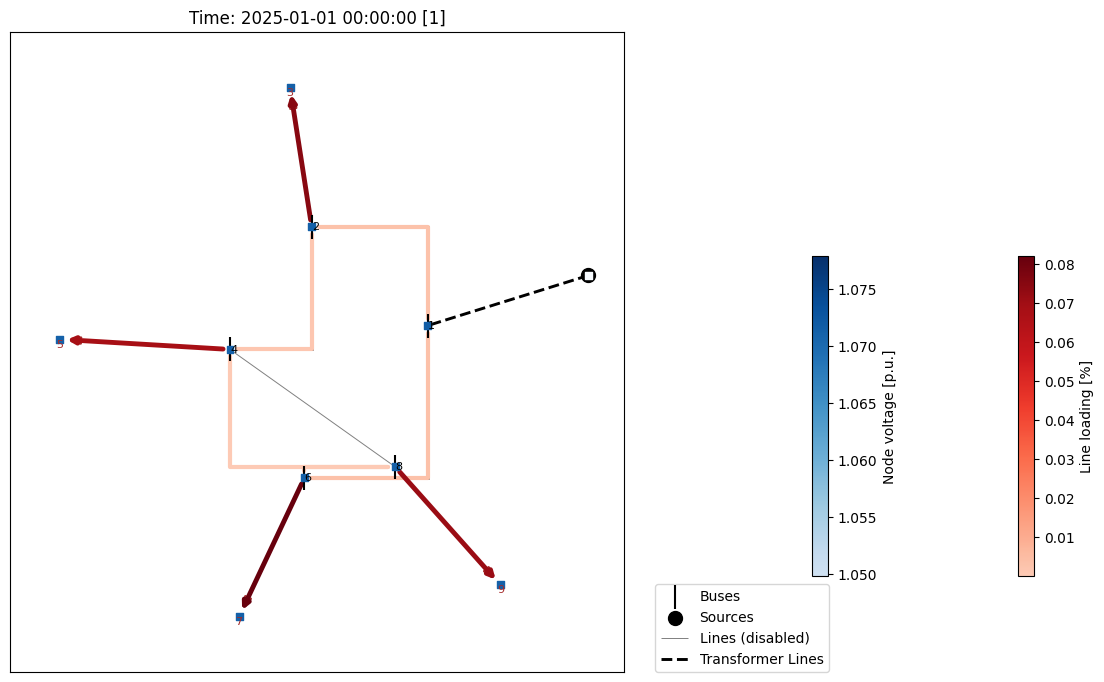

In [3]:
import os
import sys
import pytest

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
from power_grid_model.utils import json_deserialize, json_serialize

import power_system_simulation.pgm_processing as pgm_p

def test_pgm_processing():
    dir_network_json = "input_network_data.json"
    dir_active_profile = "active_power_profile.parquet"
    dir_reactive_profile = "reactive_power_profile.parquet"

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    # Read active and reactive load profile from parquet file
    active_load_profile = pd.read_parquet(dir_active_profile)
    reactive_load_profile = pd.read_parquet(dir_reactive_profile)

    p = pgm_p.PgmProcessor(network_data, active_load_profile, reactive_load_profile)
    p.create_update_model()
    p.run_batch_process()
    aggregate_results = p.get_aggregate_results()

    # Save aggregate results (for drawing tests in external notebook as repository is not completed yet and cannot be used directly as-is)
    #aggregate_results[0].to_parquet(src_dir + "/calculated_output_per_timestamp.parquet")
    #aggregate_results[1].to_parquet(src_dir + "/calculated_output_per_line.parquet")

    # Change a timestamp in active profile to an incorrect one and check for error
    active_load_profile_wrong = active_load_profile.copy()
    active_load_profile_wrong.rename(
        index={active_load_profile.index[0]: pd.to_datetime("today").normalize()}, inplace=True
    )
    with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T0") as excinfo:
        p = pgm_p.PgmProcessor(network_data, active_load_profile_wrong, reactive_load_profile)
        p.create_update_model()

    # Change a node ID in active profile to an incorrect one and check for error
    active_load_profile_wrong = active_load_profile.copy()
    active_load_profile_wrong.rename(
        columns={active_load_profile.columns[0]: 1234567890}, inplace=True
    )
    with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T1") as excinfo:
        p = pgm_p.PgmProcessor(network_data, active_load_profile_wrong, reactive_load_profile)
        p.create_update_model()

    # Change a node ID in the network description to an incorrect one (different than reactive/active profile) and check for error
    network_data_wrong = network_data.copy()
    network_data_wrong["sym_load"][0][0] = 1234567890
    with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T2") as excinfo:
        p = pgm_p.PgmProcessor(network_data_wrong, active_load_profile, reactive_load_profile)
        p.create_update_model()

    # Test if pre-calculated output data matches the aggregated output
    """
    dir_out_per_line = src_dir + "/output_table_row_per_line.parquet"
    dir_out_per_timestamp = src_dir + "/output_table_row_per_timestamp.parquet"

    assert (
        p.compare_to_expected(
            aggregate_results,
            pd.read_parquet(dir_out_per_line),
            pd.read_parquet(dir_out_per_timestamp),
        )
        == True
    )

    # Change the output data and check if the error is detected
    with pytest.raises(AssertionError) as excinfo:
        assert (
            p.compare_to_expected(
                aggregate_results,
                pd.read_parquet(dir_out_per_line),
                pd.read_parquet(dir_out_per_line),
            )
            == True
        )
        """

    # Drawing
    dir_network_json = "input_network_data.json"
    dir_active_profile = "active_power_profile.parquet"
    dir_reactive_profile = "reactive_power_profile.parquet"

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    # Read active and reactive load profile from parquet file
    active_load_profile = pd.read_parquet(dir_active_profile)
    reactive_load_profile = pd.read_parquet(dir_reactive_profile)

    p = pgm_p.PgmProcessor(network_data, active_load_profile, reactive_load_profile)
    p.create_update_model()
    p.run_batch_process()
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)
    p.draw_to_networkx(aggregate_results, ax)

    # Loading is relative loading of the line, 1.0 meaning 100% loaded.
    # For power flow: lines show loading
    # Sym loads show... whatever is chosen (default to i)
    p.draw_init_power_flow('u_pu')
    p.draw_init()
    #p.adraw_timelapse_power_flow(3)

    # p.draw_aggregate_table[0].index.size
    animation = matplotlib.animation.FuncAnimation(fig, p.draw_timelapse_power_flow, init_func=p.draw_init, frames=2, interval=250, blit=False)
    animation.save("test.gif", writer='Pillow', dpi=100)
    #p.draw_static_line_loading('min_loading')

test_pgm_processing()
